In [1]:
# 2019/04/08
# Code to analyze 20190120-n31

In [2]:
import numpy as np
import pandas as pd
from uncertainties import unumpy, ufloat

import os
import glob

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from lmfit.models import Model, ConstantModel, PolynomialModel, GaussianModel, VoigtModel, LorentzianModel, PseudoVoigtModel

sns.set_context('talk')

# Some constant variables

In [3]:
# List of files to glob
POL_LIST = glob.glob('n31-interleaving_dimers-Pol*')
UNPOL_LIST = glob.glob('n31-interleaving_dimers-Unpol*')

SET_NAME = '20190120-n31'
POL_NAME = '20190120-n31p'
UNPOL_NAME = '20190120-n31u'

ATOMIC = 1226.59
ZEEMAN = 1.60839
ORDER = 1

SATURATION_A = ufloat(44.0442405, 1.65366925)
SATURATION_B = ufloat(-0.05852900, 0.00456716)
NUM_EXPOSURES = 1000 # Number of excitation loops

# Retrieve files and do some preprocessing

### Retrieve all the data files and put in to a single DataFrame

In [4]:
# Last modified 2019/04/05
# Goes through all listed .csv files and returns data in a single DataFrame
def gather_data(file_list):
    
    # Read in .csv files in to single DataFrame
    out = pd.DataFrame()
    for file_name in file_list:
        df = pd.read_csv(file_name)
        df['Scan'] = os.path.basename(file_name)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        
        out = pd.concat([out, df], join='outer', ignore_index=True)
    
    return out

pol_data = gather_data(POL_LIST)
unpol_data = gather_data(UNPOL_LIST)

### Reduce the data by removing bad points

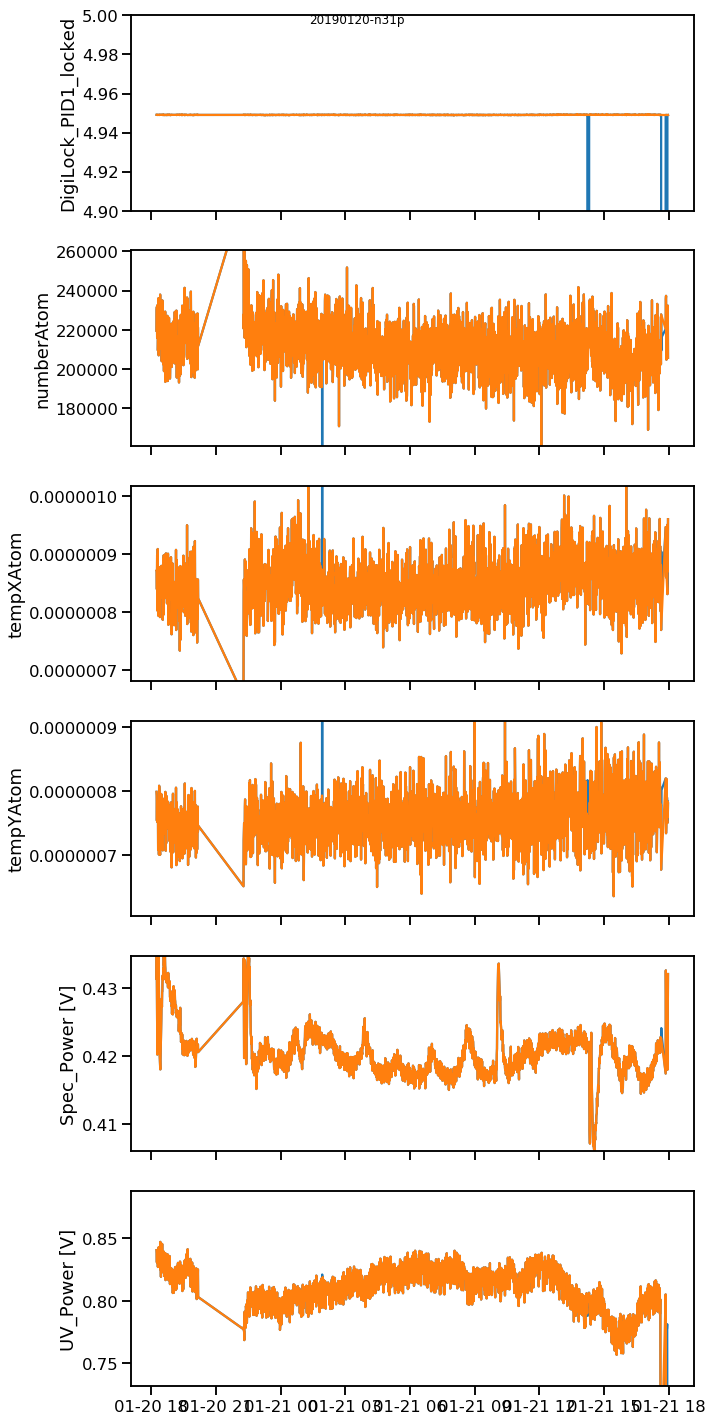

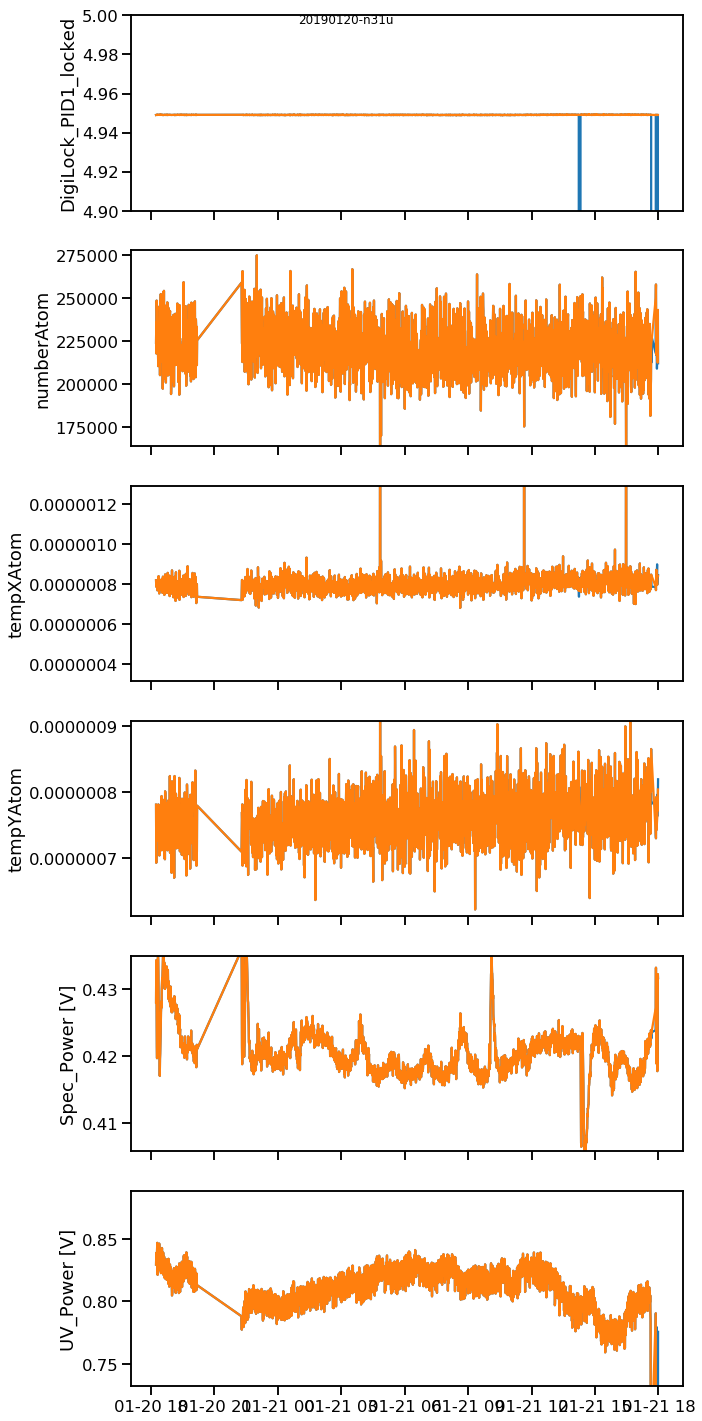

In [5]:
# First pass at removing bad data points
def reduce_data(df_data, name, show_plots):
    
    # Remove data where UV laser was not locked based on 'DigiLock_PID1_locked' column
    df_reduced = df_data[df_data['DigiLock_PID1_locked'] >= 4.9]
    
    # Remove data where atom number was above/below cutoff
    df_reduced = df_reduced[(100e3 <= df_reduced['numberAtom']) & (df_reduced['numberAtom'] <= 400e3)]
    
    # Remove data where tempYAtom was above/below cutoff
    df_reduced = df_reduced[(500E-9 <= df_reduced['tempYAtom']) & (df_reduced['tempYAtom'] <= 1.2E-6)]
    
    # Plotting original and reduced data sets
    df_orig = df_data.sort_values(by=['Timestamp'])
    df_redu = df_reduced.sort_values(by=['Timestamp'])
    
    if show_plots:
        [fig, ax]= plt.subplots(nrows=6, ncols=1, figsize=(10,20), sharex=True, sharey=False)
        fig.suptitle(name)

        ax[0].set_ylabel('DigiLock_PID1_locked')
        ax[0].plot(df_orig['Timestamp'], df_orig['DigiLock_PID1_locked'])
        ax[0].plot(df_redu['Timestamp'], df_redu['DigiLock_PID1_locked'])
        ax[0].set_ylim((4.9, 5))

        ax[1].set_ylabel('numberAtom')
        ax[1].plot(df_orig['Timestamp'], df_orig['numberAtom'])
        ax[1].plot(df_redu['Timestamp'], df_redu['numberAtom'])
        avg = np.mean(df_redu['numberAtom'])
        std = np.std(df_redu['numberAtom'])
        ax[1].set_ylim((avg-4*std, avg+4*std))

        ax[2].set_ylabel('tempXAtom')
        ax[2].plot(df_orig['Timestamp'], df_orig['tempXAtom'])
        ax[2].plot(df_redu['Timestamp'], df_redu['tempXAtom'])
        avg = np.mean(df_redu['tempXAtom'])
        std = np.std(df_redu['tempXAtom'])
        ax[2].set_ylim((avg-4*std, avg+4*std))

        ax[3].set_ylabel('tempYAtom')
        ax[3].plot(df_orig['Timestamp'], df_orig['tempYAtom'])
        ax[3].plot(df_redu['Timestamp'], df_redu['tempYAtom'])
        avg = np.mean(df_redu['tempYAtom'])
        std = np.std(df_redu['tempYAtom'])
        ax[3].set_ylim((avg-4*std, avg+4*std))

        ax[4].set_ylabel('Spec_Power [V]')
        ax[4].plot(df_orig['Timestamp'], df_orig['Spec_Power'])
        ax[4].plot(df_redu['Timestamp'], df_redu['Spec_Power'])
        avg = np.mean(df_redu['Spec_Power'])
        std = np.std(df_redu['Spec_Power'])
        ax[4].set_ylim((avg-4*std, avg+4*std))

        ax[5].set_ylabel('UV_Power [V]')
        ax[5].plot(df_orig['Timestamp'], df_orig['UV_Power'])
        ax[5].plot(df_redu['Timestamp'], df_redu['UV_Power'])
        avg = np.mean(df_redu['UV_Power'])
        std = np.std(df_redu['UV_Power'])
        ax[5].set_ylim((avg-4*std, avg+4*std))

        plt.tight_layout()
        plt.show()
    
    # Drop unused data columns
    df_reduced.drop(columns=['AI3', 'AI4', 'AI5', 'AI6', 'AI7'], inplace=True)
    
    return df_reduced

pol_reduced = reduce_data(pol_data, POL_NAME, True)
unpol_reduced = reduce_data(unpol_data, UNPOL_NAME, True)

### Aggregrate data

In [6]:
def aggregrate_data(df_data, indVar):
    df_grouped = df_data.groupby(by=indVar, as_index=False, sort=True)
    
    #df_out = df_grouped.agg([np.mean, np.std])
    df_out = df_grouped.agg({'sfiIntegral': [np.mean, np.std],
                             'UV_Power': [np.mean, np.std],
                             'Spec_Power': [np.mean, np.std],
                             'numberAtom': [np.mean, np.std],
                             'tempXAtom':  [np.mean, np.std],
                             'tempYAtom':  [np.mean, np.std]})
    df_out['count'] = df_grouped.size().values
    return df_out

indVar = ['imagevcoAtom']

pol_out = aggregrate_data(pol_reduced, indVar)
unpol_out = aggregrate_data(unpol_reduced, indVar)

### Adjust counts due to MCP saturation

In [7]:
# Using the MCP saturation curve taken on 2019/03/27 by varying the UV power, we can account for the non-linear detection.

def mcp_saturation(df):
    df_temp = df
    observed_counts = unumpy.uarray(df_temp['sfiIntegral','mean'], df_temp['sfiIntegral','std'])
    observed_counts = observed_counts/NUM_EXPOSURES
    
    corrected_counts = -SATURATION_A*unumpy.log(1-observed_counts/SATURATION_A)
    corrected_counts = NUM_EXPOSURES*corrected_counts
    
    df_temp['sfiIntegral_linearized','mean'] = unumpy.nominal_values(corrected_counts)
    df_temp['sfiIntegral_linearized', 'std'] = unumpy.std_devs(corrected_counts)
    
    return df_temp

pol_out = mcp_saturation(pol_out)
unpol_out = mcp_saturation(unpol_out)

### Calculate detunings

In [8]:
def calc_detuning(df, atomic, zeeman, order):
    df['detuning'] = order*2*(df['imagevcoAtom'] - (atomic + order*zeeman))
    
    return df

pol_out = calc_detuning(pol_out, ATOMIC, ZEEMAN, ORDER)
unpol_out = calc_detuning(unpol_out, ATOMIC, 0, ORDER)

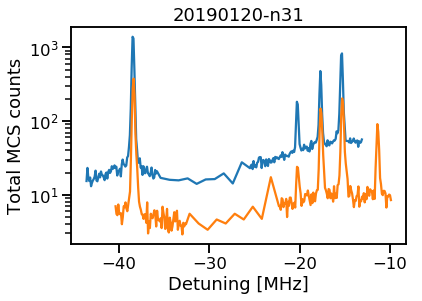

In [9]:
plt.figure()
plt.plot(pol_out['detuning'], pol_out['sfiIntegral_linearized']['mean'])
plt.plot(unpol_out['detuning'], unpol_out['sfiIntegral_linearized']['mean'])
plt.yscale('log')
plt.title(SET_NAME)
plt.xlabel('Detuning [MHz]')
plt.ylabel('Total MCS counts')
plt.show()

# Analyzing the data

In [10]:
pol_data = pol_out
unpol_data = unpol_out

### Adjust counts based on 689 nm and UV intensities

In [11]:
def adjust_for_intensities(df):
    df_temp = df
    
    raw_sfiIntegral = unumpy.uarray(df_temp['sfiIntegral_linearized', 'mean'], df_temp['sfiIntegral_linearized', 'std'])
    raw_UV_Power = unumpy.uarray(df_temp['UV_Power', 'mean'], df_temp['UV_Power', 'std'])
    raw_Spec_Power = unumpy.uarray(df_temp['Spec_Power', 'mean'], df_temp['Spec_Power', 'std'])
    
    adjusted_sfiIntegral = raw_sfiIntegral/raw_UV_Power/raw_Spec_Power
    
    df_temp['sfiIntegral_adjusted', 'mean'] = unumpy.nominal_values(adjusted_sfiIntegral)
    df_temp['sfiIntegral_adjusted', 'std'] = unumpy.std_devs(adjusted_sfiIntegral)
    
    return df_temp

# Correcting for 320 nm and 689 nm intensities point-by-point

pol_data = adjust_for_intensities(pol_data)
unpol_data = adjust_for_intensities(unpol_data)

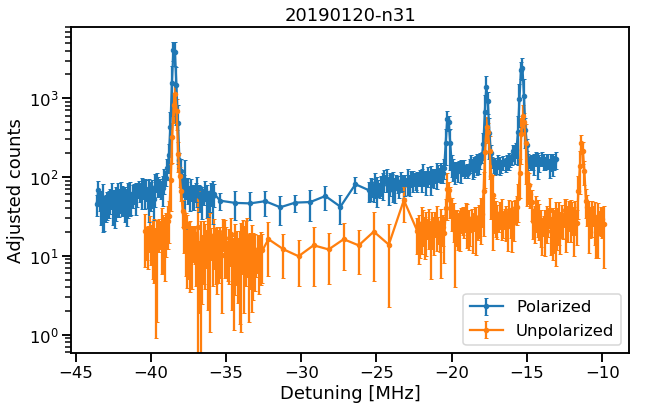

In [12]:
# Plotting results after adjusting for 320 nm and 689 nm powers

plt.figure(figsize=(10,6))
plt.errorbar(pol_data['detuning'], pol_data['sfiIntegral_adjusted', 'mean'], 
             yerr=pol_data['sfiIntegral_adjusted', 'std'],
             fmt='.-', capsize=2, label='Polarized')
plt.errorbar(unpol_data['detuning'], unpol_data['sfiIntegral_adjusted', 'mean'], 
             yerr=unpol_data['sfiIntegral_adjusted', 'std'],
             fmt='.-', capsize=2, label='Unpolarized')
plt.gca().set_yscale('log')
plt.title(SET_NAME)
plt.xlabel('Detuning [MHz]')
plt.ylabel('Adjusted counts')
plt.legend()
plt.show()

### 2019/07/16 - Saving spectra to excel file

In [13]:
# Flattening Pandas multiindex
# See: https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns
pol_data_out = pol_data.copy(deep=True)
unpol_data_out = unpol_data.copy(deep=True)

pol_data_out.columns = [' '.join(col).strip() for col in pol_data_out.columns.values]
unpol_data_out.columns = [' '.join(col).strip() for col in unpol_data_out.columns.values]

with pd.ExcelWriter('20190117-n31-exp_spectra.xlsx') as writer:
    pol_data_out.to_excel(writer, sheet_name='polarized')
    unpol_data_out.to_excel(writer, sheet_name='unpolarized')

## Fitting the data

### n=31, polarized sample

#### n=31, polarized, dimer, ground state

[[Model]]
    (Model(polynomial, prefix='bg_') + Model(pvoigt, prefix='d0_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 64
    # variables        = 5
    chi-square         = 16383.3445
    reduced chi-square = 277.683804
    Akaike info crit   = 364.888796
    Bayesian info crit = 375.683211
[[Variables]]
    bg_c0:         52.2290900 +/- 2.48196533 (4.75%) (init = 47.0985)
    d0_fraction:   0.42318589 +/- 0.02125458 (5.02%) (init = 0.5)
    d0_sigma:      0.11405540 +/- 7.1981e-04 (0.63%) (init = 0.1)
    d0_center:    -38.4503693 +/- 3.9502e-04 (0.00%) (init = -38.45)
    d0_amplitude:  1276.88470 +/- 9.28409041 (0.73%) (init = 1123)
    d0_fwhm:       0.22811080 +/- 0.00143962 (0.63%) == '2.0000000*d0_sigma'
    d0_height:     4541.31380 +/- 19.9798711 (0.44%) == '(((1-d0_fraction)*d0_amplitude)/(d0_sigma*sqrt(pi/log(2)))+(d0_fraction*d0_amplitude)/(pi*d0_sigma))'
[[Correlations]] (unreported correlations are < 0.100)


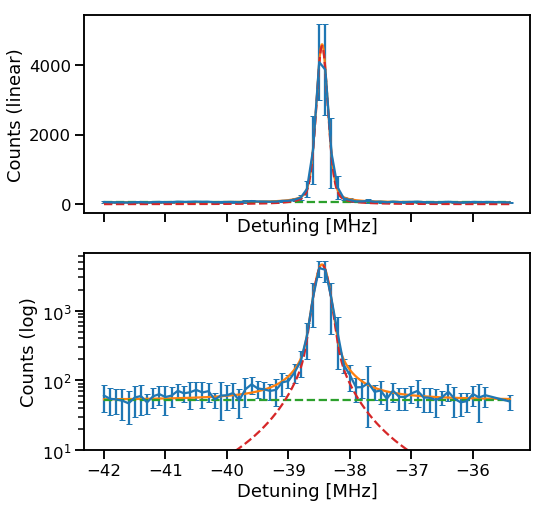

In [14]:
data = pol_data
plot_components = True
plot_initial_guess = False

# Choosing a range to fit over
xmin = -42
xmax = -35

xdata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['detuning']
ydata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'mean']
ydata_unc = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'std']

# Specify fit model
bg = PolynomialModel(degree=0, prefix='bg_')
d0 = PseudoVoigtModel(prefix='d0_')

fit_model = bg + d0
fit_params = fit_model.make_params()

fit_params['bg_c0'].set(min(ydata), vary=True)
#fit_params['bg_c1'].set(0, vary=True)
#fit_params['bg_c2'].set(0, vary=True)

fit_params['d0_center'].set(-38.45, vary=True)
fit_params['d0_amplitude'].set(1123, min=0, vary=True)
fit_params['d0_sigma'].set(0.1, min=0, vary=True)

# Initial guess
xfit = np.linspace(min(xdata), max(xdata), num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, x=xfit)

# Fitting
fit_result = fit_model.fit(ydata, fit_params, x=xdata)
dely = fit_result.eval_uncertainty(x=xdata)
yfit = fit_model.eval(fit_result.params, x=xfit)

print(fit_result.fit_report())

# Plotting output
[fig, axs] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

axs[0].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[0].plot(xfit, yfit, label='fit')
axs[0].set_xlabel('Detuning [MHz]')
axs[0].set_ylabel('Counts (linear)')

axs[1].set_yscale('log')
axs[1].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[1].plot(xfit, yfit, label='fit')
axs[1].set_xlabel('Detuning [MHz]')
axs[1].set_ylabel('Counts (log)')
axs[1].set_ylim(bottom=10)

if plot_components:
    # generate components
    fit_comps = fit_result.eval_components(x=xfit)
    
    for key in fit_comps.keys():
        for ax in axs:
            ax.plot(xfit, fit_comps[key], '--')

if plot_initial_guess:
    for ax in axs:
        ax.plot(xfit, yinit, '-.', label='init')

plt.show()

In [15]:
# Extracting the fitted parameters

labview_params = [('numberAtom', 'mean'), ('tempXAtom', 'mean'), ('tempYAtom', 'mean'), ('UV_Power', 'mean'), ('Spec_Power', 'mean')]

print('Xmin [MHz]:\t' + str(min(xdata)))
print('Xmax [MHz]:\t' + str(max(xdata)))
for p in labview_params:
    print(p[0] + '(mean):\t' + str(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))
    print(p[0] + '(std):\t' + str(np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))

# Saving to variables
d0_pol_int = ufloat(fit_result.params['d0_amplitude'].value, fit_result.params['d0_amplitude'].stderr)
d0_pol_N = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']),
                  np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']))
d0_pol_Tx = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempXAtom', 'mean']),
                   np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempXAtom', 'mean']))
d0_pol_Ty = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']),
                   np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']))

d0_pol_height = ufloat(fit_result.params['d0_height'].value, fit_result.params['d0_height'].stderr)

Xmin [MHz]:	-41.996779999999944
Xmax [MHz]:	-35.396780000000035
numberAtom(mean):	210818.40924715903
numberAtom(std):	3898.2890928181173
tempXAtom(mean):	8.497107005397724e-07
tempXAtom(std):	1.2525936013197146e-08
tempYAtom(mean):	7.602931297017047e-07
tempYAtom(std):	1.2286187747324145e-08
UV_Power(mean):	0.8110258267142556
UV_Power(std):	0.004415053069301236
Spec_Power(mean):	0.4204327860745516
Spec_Power(std):	0.0012318032975916601


#### n=31, polarized, dimer, 1st and 2nd excited states

C:\Users\reyalp\Anaconda3\lib\site-packages\lmfit\lineshapes.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  return (amplitude/(s2pi*sigma)) * exp(-(1.0*x-center)**2 / (2*sigma**2))


[[Model]]
    ((((Model(polynomial, prefix='bg_') + Model(pvoigt, prefix='a_')) + Model(pvoigt, prefix='dx_')) + Model(pvoigt, prefix='d1_')) + Model(pvoigt, prefix='d2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3631
    # data points      = 90
    # variables        = 16
    chi-square         = 12500.3242
    reduced chi-square = 168.923300
    Akaike info crit   = 476.033017
    Bayesian info crit = 516.029972
[[Variables]]
    bg_c0:         1.2744e-06 +/- 3446.23895 (270419182417.35%) (init = 87.31304)
    a_fraction:    6.6893e-07 +/- 51.2552979 (7662259568.90%) (init = 0.5)
    a_sigma:       23.2496239 +/- 288.537974 (1241.04%) (init = 0.1)
    a_center:      0 (fixed)
    a_amplitude:   9331.80924 +/- 448986.895 (4811.36%) (init = 9332)
    dx_fraction:   0.18241395 +/- 0.21652718 (118.70%) (init = 0.5)
    dx_sigma:      0.11815238 +/- 0.00480496 (4.07%) (init = 0.1)
    dx_center:    -20.2521352 +/- 0.00304957 (0.02%) (init = -20.25)
   

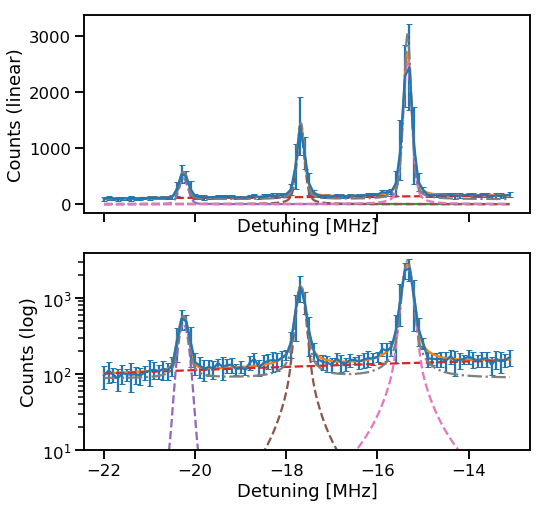

In [16]:
data = pol_data
plot_components = True
plot_initial_guess = True

# Choosing a range to fit over
xmin = -22
xmax = -12.5

xdata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['detuning']
ydata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'mean']
ydata_unc = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'std']

# Specify fit model
bg = PolynomialModel(degree=0, prefix='bg_')
a = PseudoVoigtModel(prefix='a_')
d1 = PseudoVoigtModel(prefix='d1_')
d2 = PseudoVoigtModel(prefix='d2_')
dx = PseudoVoigtModel(prefix='dx_')

fit_model = bg + a + dx + d1 + d2
fit_params = fit_model.make_params()

fit_params['bg_c0'].set(min(ydata), min=0, max=200, vary=True)
#fit_params['bg_c1'].set(2, vary=True)
#fit_params['bg_c2'].set(0, vary=True)

fit_params['a_center'].set(0, vary=False)
fit_params['a_amplitude'].set(9332, vary=True)
fit_params['a_sigma'].set(0.1, min=0, vary=True)

fit_params['dx_center'].set(-20.25, vary=True)
fit_params['dx_amplitude'].set(123, min=0, vary=True)
fit_params['dx_sigma'].set(0.1, min=0, vary=True)

fit_params['d1_center'].set(-17.68, vary=True)
fit_params['d1_amplitude'].set(345, min=0, vary=True)
fit_params['d1_sigma'].set(0.1, min=0, vary=True)

fit_params['d2_center'].set(-15.34, vary=True)
fit_params['d2_amplitude'].set(748, min=0, vary=True)
fit_params['d2_sigma'].set(0.1, min=0, vary=True)

# Initial guess
xfit = np.linspace(min(xdata), max(xdata), num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, x=xfit)

# Fitting
fit_result = fit_model.fit(ydata, fit_params, x=xdata)
dely = fit_result.eval_uncertainty(x=xdata)
yfit = fit_model.eval(fit_result.params, x=xfit)

print(fit_result.fit_report())

# Plotting output
[fig, axs] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

axs[0].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[0].plot(xfit, yfit, label='fit')
axs[0].set_xlabel('Detuning [MHz]')
axs[0].set_ylabel('Counts (linear)')

axs[1].set_yscale('log')
axs[1].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[1].plot(xfit, yfit, label='fit')
axs[1].set_xlabel('Detuning [MHz]')
axs[1].set_ylabel('Counts (log)')
axs[1].set_ylim(bottom=10)

if plot_components:
    # generate components
    fit_comps = fit_result.eval_components(x=xfit)
    
    for key in fit_comps.keys():
        for ax in axs:
            ax.plot(xfit, fit_comps[key], '--')

if plot_initial_guess:
    for ax in axs:
        ax.plot(xfit, yinit, '-.', label='init')

plt.show()

In [17]:
# Extracting the fitted parameters

labview_params = [('numberAtom', 'mean'), ('tempXAtom', 'mean'), ('tempYAtom', 'mean'), ('UV_Power', 'mean'), ('Spec_Power', 'mean')]

print('Xmin [MHz]:\t' + str(min(xdata)))
print('Xmax [MHz]:\t' + str(max(xdata)))
for p in labview_params:
    print(p[0] + '(mean):\t' + str(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))
    print(p[0] + '(std):\t' + str(np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))

# Saving to variables
d1_pol_int = ufloat(fit_result.params['d1_amplitude'].value, fit_result.params['d1_amplitude'].stderr)
d1_pol_N = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']),
                  np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']))
d1_pol_Tx = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempXAtom', 'mean']),
                   np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempXAtom', 'mean']))
d1_pol_Ty = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']),
                   np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']))

d2_pol_int = ufloat(fit_result.params['d2_amplitude'].value, fit_result.params['d2_amplitude'].stderr)
d2_pol_N = d1_pol_N
d2_pol_Tx = d1_pol_Tx
d2_pol_Ty = d1_pol_Ty

Xmin [MHz]:	-21.996779999999944
Xmax [MHz]:	-13.096779999999853
numberAtom(mean):	209863.5578383838
numberAtom(std):	3916.58381316811
tempXAtom(mean):	8.509622256060606e-07
tempXAtom(std):	1.2832370542862348e-08
tempYAtom(mean):	7.554211713838382e-07
tempYAtom(std):	1.0878452755752367e-08
UV_Power(mean):	0.8093512591737693
UV_Power(std):	0.0023620217499304872
Spec_Power(mean):	0.4198960928868766
Spec_Power(std):	0.000536197068316391


### n=31, unpolarized sample

#### n=31, unpolarized, dimer, ground state

[[Model]]
    (Model(polynomial, prefix='bg_') + Model(pvoigt, prefix='d0_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 54
    # variables        = 5
    chi-square         = 3243.78230
    reduced chi-square = 66.1996388
    Akaike info crit   = 231.157608
    Bayesian info crit = 241.102528
[[Variables]]
    bg_c0:         13.3600651 +/- 1.37556019 (10.30%) (init = 8.716527)
    d0_fraction:   0.36103570 +/- 0.03709201 (10.27%) (init = 0.5)
    d0_sigma:      0.13095052 +/- 0.00124869 (0.95%) (init = 0.1)
    d0_center:    -38.3933241 +/- 8.6090e-04 (0.00%) (init = -38.5)
    d0_amplitude:  351.083791 +/- 4.81573457 (1.37%) (init = 276.46)
    d0_fwhm:       0.26190104 +/- 0.00249739 (0.95%) == '2.0000000*d0_sigma'
    d0_height:     1112.77886 +/- 8.01615192 (0.72%) == '(((1-d0_fraction)*d0_amplitude)/(d0_sigma*sqrt(pi/log(2)))+(d0_fraction*d0_amplitude)/(pi*d0_sigma))'
[[Correlations]] (unreported correlations are < 0.1

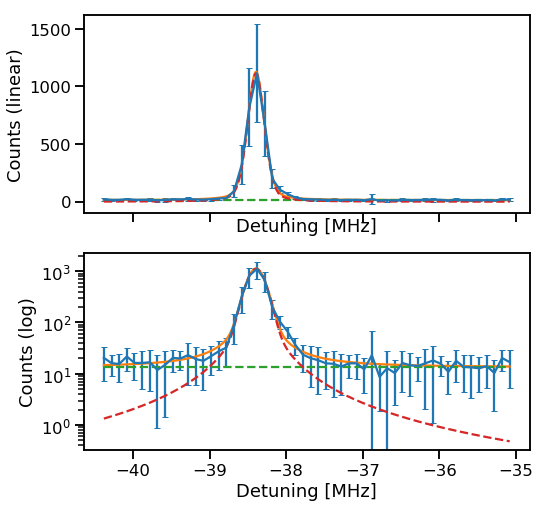

In [18]:
data = unpol_data
plot_components = True
plot_initial_guess = False

# Choosing a range to fit over
xmin = -42
xmax = -35

xdata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['detuning']
ydata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'mean']
ydata_unc = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'std']

# Specify fit model
bg = PolynomialModel(degree=0, prefix='bg_')
d0 = PseudoVoigtModel(prefix='d0_')

fit_model = bg + d0
fit_params = fit_model.make_params()

fit_params['bg_c0'].set(min(ydata), vary=True)
#fit_params['bg_c1'].set(0, vary=True)
#fit_params['bg_c2'].set(0, vary=True)

fit_params['d0_center'].set(-38.5, vary=True)
fit_params['d0_amplitude'].set(276.46, min=0, vary=True)
fit_params['d0_sigma'].set(0.1, min=0, vary=True)

# Initial guess
xfit = np.linspace(min(xdata), max(xdata), num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, x=xfit)

# Fitting
fit_result = fit_model.fit(ydata, fit_params, x=xdata)
dely = fit_result.eval_uncertainty(x=xdata)
yfit = fit_model.eval(fit_result.params, x=xfit)

print(fit_result.fit_report())

# Plotting output
[fig, axs] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

axs[0].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[0].plot(xfit, yfit, label='fit')
axs[0].set_xlabel('Detuning [MHz]')
axs[0].set_ylabel('Counts (linear)')

axs[1].set_yscale('log')
axs[1].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[1].plot(xfit, yfit, label='fit')
axs[1].set_xlabel('Detuning [MHz]')
axs[1].set_ylabel('Counts (log)')

if plot_components:
    # generate components
    fit_comps = fit_result.eval_components(x=xfit)
    
    for key in fit_comps.keys():
        for ax in axs:
            ax.plot(xfit, fit_comps[key], '--')

if plot_initial_guess:
    for ax in axs:
        ax.plot(xfit, yinit, '-.', label='init')

plt.show()

In [19]:
# Extracting the fitted parameters

labview_params = [('numberAtom', 'mean'), ('tempXAtom', 'mean'), ('tempYAtom', 'mean'), ('UV_Power', 'mean'), ('Spec_Power', 'mean')]

print('Xmin [MHz]:\t' + str(min(xdata)))
print('Xmax [MHz]:\t' + str(max(xdata)))
for p in labview_params:
    print(p[0] + '(mean):\t' + str(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))
    print(p[0] + '(std):\t' + str(np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))

# Saving to variables
d0_unpol_int = ufloat(fit_result.params['d0_amplitude'].value, fit_result.params['d0_amplitude'].stderr)
d0_unpol_N = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']),
                    np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']))
d0_unpol_Tx = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempXAtom', 'mean']),
                     np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempXAtom', 'mean']))
d0_unpol_Ty = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']),
                     np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']))

d0_unpol_height = ufloat(fit_result.params['d0_height'].value, fit_result.params['d0_height'].stderr)

Xmin [MHz]:	-40.379999999999654
Xmax [MHz]:	-35.07999999999993
numberAtom(mean):	221040.79784511786
numberAtom(std):	4439.858441299119
tempXAtom(mean):	7.98201757087542e-07
tempXAtom(std):	9.917364440447781e-09
tempYAtom(mean):	7.610168398653201e-07
tempYAtom(std):	1.1121523793451945e-08
UV_Power(mean):	0.8090826827026779
UV_Power(std):	0.0067634343245876385
Spec_Power(mean):	0.4216646208586515
Spec_Power(std):	0.0010918700207892737


#### n=31, unpolarized, dimer, 1st and 2nd excited states

[[Model]]
    ((((Model(polynomial, prefix='bg_') + Model(pvoigt, prefix='a_')) + Model(pvoigt, prefix='dx_')) + Model(pvoigt, prefix='d1_')) + Model(pvoigt, prefix='d2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 252
    # data points      = 95
    # variables        = 16
    chi-square         = 6368.20202
    reduced chi-square = 80.6101522
    Akaike info crit   = 431.493578
    Bayesian info crit = 472.355608
[[Variables]]
    bg_c0:         24.1709295 +/- 4.07885395 (16.88%) (init = 14.63307)
    a_fraction:    0.00225958 +/- 14977.0555 (662824607.79%) (init = 0.5)
    a_sigma:       5.2999e-04 +/- 3449.53523 (650864895.99%) (init = 0.1)
    a_center:      0 (fixed)
    a_amplitude:  -44872.6308 +/- 1.2235e+11 (272660108.44%) (init = 9332)
    dx_fraction:   5.5579e-08 +/- 0.33662339 (605663267.54%) (init = 0.5)
    dx_sigma:      0.14054639 +/- 0.02973694 (21.16%) (init = 0.1)
    dx_center:    -20.2065256 +/- 0.02149003 (0.11%) (init = -20.25

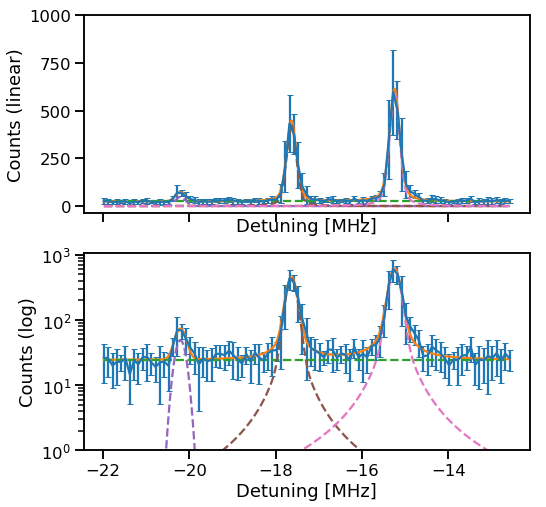

In [20]:
data = unpol_data
plot_components = True
plot_initial_guess = False

# Choosing a range to fit over
xmin = -22
xmax = -12.5

xdata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['detuning']
ydata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'mean']
ydata_unc = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'std']

# Specify fit model
bg = PolynomialModel(degree=0, prefix='bg_')
a = PseudoVoigtModel(prefix='a_')
d1 = PseudoVoigtModel(prefix='d1_')
d2 = PseudoVoigtModel(prefix='d2_')
dx = PseudoVoigtModel(prefix='dx_')

fit_model = bg + a + dx + d1 + d2
fit_params = fit_model.make_params()

fit_params['bg_c0'].set(min(ydata), min=0, max=200, vary=True)
#fit_params['bg_c1'].set(2, vary=True)
#fit_params['bg_c2'].set(0, vary=True)

fit_params['a_center'].set(0, vary=False)
fit_params['a_amplitude'].set(9332, vary=True)
fit_params['a_sigma'].set(0.1, min=0, vary=True)

fit_params['dx_center'].set(-20.25, vary=True)
fit_params['dx_amplitude'].set(123, min=0, vary=True)
fit_params['dx_sigma'].set(0.1, min=0, vary=True)

fit_params['d1_center'].set(-17.68, vary=True)
fit_params['d1_amplitude'].set(345, min=0, vary=True)
fit_params['d1_sigma'].set(0.1, min=0, vary=True)

fit_params['d2_center'].set(-15.34, vary=True)
fit_params['d2_amplitude'].set(748, min=0, vary=True)
fit_params['d2_sigma'].set(0.1, min=0, vary=True)

# Initial guess
xfit = np.linspace(min(xdata), max(xdata), num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, x=xfit)

# Fitting
fit_result = fit_model.fit(ydata, fit_params, x=xdata)
dely = fit_result.eval_uncertainty(x=xdata)
yfit = fit_model.eval(fit_result.params, x=xfit)

print(fit_result.fit_report())

# Plotting output
[fig, axs] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

axs[0].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[0].plot(xfit, yfit, label='fit')
axs[0].set_xlabel('Detuning [MHz]')
axs[0].set_ylabel('Counts (linear)')
axs[0].set_ylim(top=1000)

axs[1].set_yscale('log')
axs[1].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[1].plot(xfit, yfit, label='fit')
axs[1].set_xlabel('Detuning [MHz]')
axs[1].set_ylabel('Counts (log)')
axs[1].set_ylim(bottom=1)

if plot_components:
    # generate components
    fit_comps = fit_result.eval_components(x=xfit)
    
    for key in fit_comps.keys():
        for ax in axs:
            ax.plot(xfit, fit_comps[key], '--')

if plot_initial_guess:
    for ax in axs:
        ax.plot(xfit, yinit, '-.', label='init')

plt.show()

In [21]:
# Extracting the fitted parameters

labview_params = [('numberAtom', 'mean'), ('tempXAtom', 'mean'), ('tempYAtom', 'mean'), ('UV_Power', 'mean'), ('Spec_Power', 'mean')]

print('Xmin [MHz]:\t' + str(min(xdata)))
print('Xmax [MHz]:\t' + str(max(xdata)))
for p in labview_params:
    print(p[0] + '(mean):\t' + str(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))
    print(p[0] + '(std):\t' + str(np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))

# Saving to variables
d1_unpol_int = ufloat(fit_result.params['d1_amplitude'].value, fit_result.params['d1_amplitude'].stderr)
d1_unpol_N = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']),
                  np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']))
d1_unpol_Tx = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempXAtom', 'mean']),
                   np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempXAtom', 'mean']))
d1_unpol_Ty = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']),
                   np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']))

d2_unpol_int = ufloat(fit_result.params['d2_amplitude'].value, fit_result.params['d2_amplitude'].stderr)
d2_unpol_N = d1_unpol_N
d2_unpol_Tx = d1_unpol_Tx
d2_unpol_Ty = d1_unpol_Ty

Xmin [MHz]:	-21.980000000000018
Xmax [MHz]:	-12.579999999999927
numberAtom(mean):	221050.00574162678
numberAtom(std):	4426.379148973492
tempXAtom(mean):	8.08435857320574e-07
tempXAtom(std):	5.206039094380377e-08
tempYAtom(mean):	7.608653779904305e-07
tempYAtom(std):	9.399578295974125e-09
UV_Power(mean):	0.8102710252971739
UV_Power(std):	0.002364393635872589
Spec_Power(mean):	0.4202835418847191
Spec_Power(std):	0.0003517037569643137


# Some uncertainty calculations

In [22]:
d0_pol_int_corr = d0_pol_int/(d0_pol_N**2/d0_pol_Ty**(3/2))
d1_pol_int_corr = d1_pol_int/(d1_pol_N**2/d1_pol_Ty**(3/2))
d2_pol_int_corr = d2_pol_int/(d2_pol_N**2/d2_pol_Ty**(3/2))

d0_unpol_int_corr = d0_unpol_int/(d0_unpol_N**2/d0_unpol_Ty**(3/2))
d1_unpol_int_corr = d1_unpol_int/(d1_unpol_N**2/d1_unpol_Ty**(3/2))
d2_unpol_int_corr = d2_unpol_int/(d2_unpol_N**2/d2_unpol_Ty**(3/2))

In [23]:
d1_pol_int_corr/d0_pol_int_corr
d2_pol_int_corr/d0_pol_int_corr

d1_unpol_int_corr/d0_unpol_int_corr
d2_unpol_int_corr/d0_unpol_int_corr

0.6007084541365437+/-0.04504713110219444

### Correcting for Tx and Ty (2019/04/24)

In [24]:
d0_pol_int_corr = d0_pol_int/(d0_pol_N**2/(d0_pol_Tx*d0_pol_Ty**(1/2)))
d1_pol_int_corr = d1_pol_int/(d1_pol_N**2/(d1_pol_Tx*d1_pol_Ty**(1/2)))
d2_pol_int_corr = d2_pol_int/(d2_pol_N**2/(d2_pol_Tx*d2_pol_Ty**(1/2)))

d0_unpol_int_corr = d0_unpol_int/(d0_unpol_N**2/(d0_unpol_Tx*d0_unpol_Ty**(1/2)))
d1_unpol_int_corr = d1_unpol_int/(d1_unpol_N**2/(d1_unpol_Tx*d1_unpol_Ty**(1/2)))
d2_unpol_int_corr = d2_unpol_int/(d2_unpol_N**2/(d2_unpol_Tx*d2_unpol_Ty**(1/2)))

In [25]:
d1_pol_int_corr/d0_pol_int_corr
d2_pol_int_corr/d0_pol_int_corr

d1_unpol_int_corr/d0_unpol_int_corr
d2_unpol_int_corr/d0_unpol_int_corr

0.6085315181561858+/-0.05834418409775344

In [26]:
print('Dimer ratios for checking')
print(d1_pol_int_corr/d0_pol_int_corr)
print(d2_pol_int_corr/d0_pol_int_corr)

print(d1_unpol_int_corr/d0_unpol_int_corr)
print(d2_unpol_int_corr/d0_unpol_int_corr)

Dimer ratios for checking
0.272+/-0.017
0.590+/-0.035
0.41+/-0.04
0.61+/-0.06


In [27]:
d0_pol_height

4541.313804674898+/-19.979871118974838

In [28]:
d0_unpol_height

1112.7788646235679+/-8.016151918604534